Saving children-born-per-woman.csv to children-born-per-woman.csv
Saving female-labor-force-participation-oecd.csv to female-labor-force-participation-oecd.csv
Saving marriage-rate-per-1000-inhabitants.csv to marriage-rate-per-1000-inhabitants.csv
Saving mean-years-of-schooling-female.csv to mean-years-of-schooling-female.csv
Saving period-average-age-of-mothers-birth-order.csv to period-average-age-of-mothers-birth-order.csv


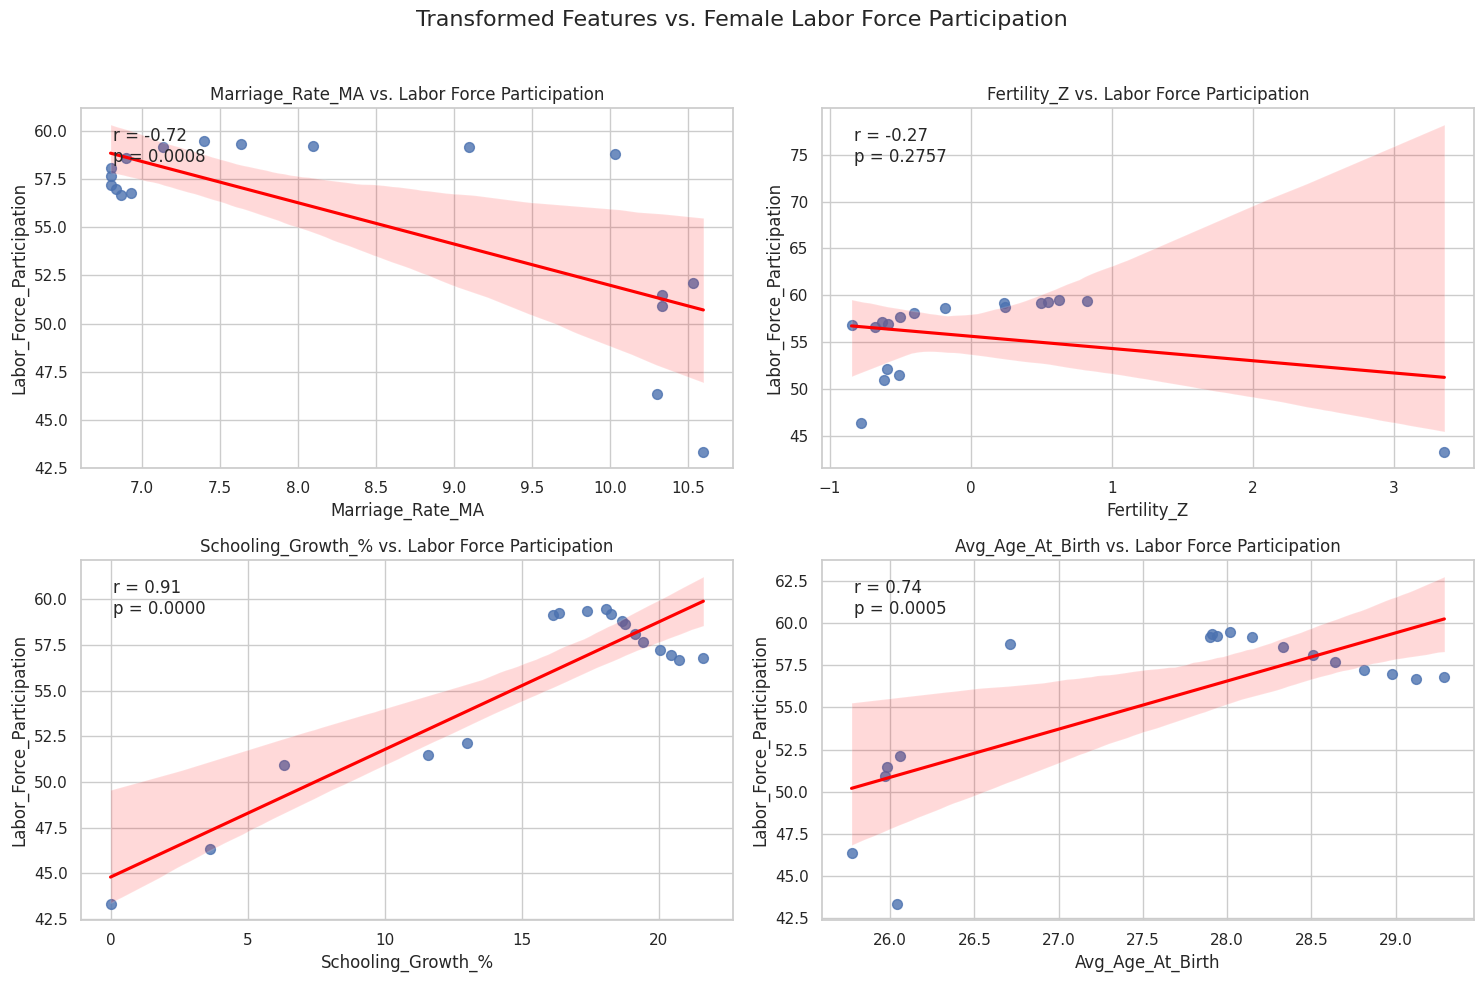

Correlation Analysis Results:

🔸 Marriage_Rate_MA
   r = -0.72, p = 0.0008
   → a moderate negative correlation (p sig)

🔸 Fertility_Z
   r = -0.27, p = 0.2757
   → a very weak or negligible negative correlation (p not sig)

🔸 Schooling_Growth_%
   r = 0.91, p = 0.0000
   → a strong positive correlation (p sig)

🔸 Avg_Age_At_Birth
   r = 0.74, p = 0.0005
   → a moderate positive correlation (p sig)

 Summary:
- Education growth: strong positive ↗
- Avg. maternal age: moderate-positive ↗
- Smoothed marriage rate: moderate-negative ↘
- Fertility rate: very weak/non-significant


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from google.colab import files


uploaded = files.upload()


labor      = pd.read_csv("female-labor-force-participation-oecd.csv")
marriage   = pd.read_csv("marriage-rate-per-1000-inhabitants.csv")
fertility  = pd.read_csv("children-born-per-woman.csv")
schooling  = pd.read_csv("mean-years-of-schooling-female.csv")
birth_age  = pd.read_csv("period-average-age-of-mothers-birth-order.csv")

# Filter & rename labor, marriage, fertility, birth_age (these stay the same)
labor = labor[labor['Entity']=="United States"][['Year',
    'Female labor force participation rate (OWID based on OECD 2017 and others)']].rename(
    columns={'Female labor force participation rate (OWID based on OECD 2017 and others)': 'Labor_Force_Participation'})

marriage = marriage[marriage['Entity']=="United States"][['Year',
    'Crude marriage rate (marriages per 1,000 people)']].rename(
    columns={'Crude marriage rate (marriages per 1,000 people)': 'Marriage_Rate'})

fertility = fertility[fertility['Entity']=="United States"][['Year',
    'Fertility rate (period), historical']].rename(
    columns={'Fertility rate (period), historical': 'Fertility_Rate'})

birth_age = birth_age[birth_age['Entity']=="United States"][['Year',
    'Period mean ages at birth - Total']].rename(
    columns={'Period mean ages at birth - Total': 'Avg_Age_At_Birth'})

# find schooling column
#    (pick the first header containing 'schooling' in its name)
schooling_cols = [c for c in schooling.columns if 'schooling' in c.lower()]
if not schooling_cols:
    raise KeyError(f"Could not find any column containing 'schooling' in {schooling.columns.tolist()}")
school_col = schooling_cols[0]

# Filter & rename schooling
schooling = schooling[schooling['Entity']=="United States"][['Year', school_col]].rename(
    columns={school_col: 'Schooling_Years'})

# Merge everything on Year
df = (labor
      .merge(marriage, on='Year')
      .merge(fertility, on='Year')
      .merge(schooling, on='Year')
      .merge(birth_age, on='Year'))

# Transformations
df['Marriage_Rate_MA']    = df['Marriage_Rate'].rolling(window=3, min_periods=1).mean()
df['Fertility_Z']         = (df['Fertility_Rate'] - df['Fertility_Rate'].mean())/df['Fertility_Rate'].std()
base_schooling            = df['Schooling_Years'].iloc[0]
df['Schooling_Growth_%']  = 100*(df['Schooling_Years'] - base_schooling)/base_schooling

def age_bin(age):
    if age < 26:      return '<26'
    elif age <= 28:   return '26-28'
    else:             return '>28'

df['Birth_Age_Group'] = df['Avg_Age_At_Birth'].apply(age_bin)

# EDA & Visualization
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Transformed Features vs. Female Labor Force Participation", fontsize=16)

features = ['Marriage_Rate_MA', 'Fertility_Z', 'Schooling_Growth_%', 'Avg_Age_At_Birth']
correlation_results = {}

for i, feat in enumerate(features):
    ax = axes[i//2, i%2]
    sns.regplot(data=df, x=feat, y='Labor_Force_Participation', ax=ax,
                scatter_kws={'s':50}, line_kws={'color':'red'})
    ax.set_title(f"{feat} vs. Labor Force Participation")
    r, p = pearsonr(df[feat], df['Labor_Force_Participation'])
    correlation_results[feat] = (r, p)
    ax.annotate(f"r = {r:.2f}\np = {p:.4f}", xy=(0.05,0.85), xycoords='axes fraction')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# Results Interpretation
print("Correlation Analysis Results:\n")
for var, (r, p) in correlation_results.items():
    abs_r = abs(r)
    strength = ("a strong" if abs_r>=0.8 else
                "a moderate" if abs_r>=0.5 else
                "a weak" if abs_r>=0.3 else
                "a very weak or negligible")
    direction = "positive" if r>0 else "negative"
    significance = "statistically significant" if p<0.05 else "not statistically significant"
    print(f"🔸 {var}")
    print(f"   r = {r:.2f}, p = {p:.4f}")
    print(f"   → {strength} {direction} correlation (p {'' if p<0.05 else 'not '}sig)\n")

print(" Summary:")
print("- Education growth: strong positive ↗")
print("- Avg. maternal age: moderate-positive ↗")
print("- Smoothed marriage rate: moderate-negative ↘")
print("- Fertility rate: very weak/non-significant")

# --- Summary of Findings: ----
# chooling Growth: Strong positive correlation with labor force participation. → As women’s education increases, more women join the workforce.
# Avg. Age at Birth: Moderate-to-strong positive correlation. → Women who delay childbirth are more likely to participate in the workforce.
# Marriage Rate (Smoothed): Strong negative correlation. → Higher marriage rates are associated with fewer women in the labor force.
# Fertility Rate: Weak negative correlation, not statistically significant. → Number of children does not appear to strongly affect workforce participation.

